<a href="https://colab.research.google.com/github/hassaanakram/plant-disease-detection/blob/master/Plant_Disease_(disease_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Diseases detection
This project aims to create a plant disease detection app using the 'New Plant Diseases' dataset from Kaggle. This notebook holds the code for disease classification network from the input image of a 'single' leaf.

In this first part of the pipeline, a model is trained to identify disease given image of leaf.


In [ ]:
a =  []
while(1):
  a.append('1')

In [3]:
# Kaggle import
from  google.colab import files
!pip install -q kaggle

In [ ]:
# Uploading kaggle api token
api_token =  files.upload()

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [6]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.67G/2.70G [00:51<00:00, 58.7MB/s]
100% 2.70G/2.70G [00:51<00:00, 56.2MB/s]


In [ ]:
! unzip new-plant-diseases-dataset.zip -d '/content/Dataset'

In [41]:
# Imports for nn model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

In [28]:
tf.random.set_seed(123)

In [29]:
import pathlib
data_dir = '/content/Dataset/New Plant Diseases Dataset(Augmented)'
data_dir = pathlib.Path(data_dir)
#print(data_dir)
#img_count = len(list(data_dir.glob('*/*.JPG')))
#print(img_count)
train_dir = os.path.join(data_dir, "New Plant Diseases Dataset(Augmented)/train")
validation_dir = os.path.join(data_dir, "New Plant Diseases Dataset(Augmented)/valid")
test_dir =  os.path.join(data_dir, "test")

path_object = pathlib.Path(train_dir)
classes = [(tf.strings.split(str(f), os.path.sep))[-1] for f in path_object.iterdir() if f.is_dir()]

In [ ]:
print(classes)
print(len(classes))

[<tf.Tensor: shape=(), dtype=string, numpy=b'Tomato___Spider_mites Two-spotted_spider_mite'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Apple___Cedar_apple_rust'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Tomato___Septoria_leaf_spot'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Potato___Late_blight'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Tomato___Tomato_Yellow_Leaf_Curl_Virus'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Peach___Bacterial_spot'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Apple___Apple_scab'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Grape___Esca_(Black_Measles)'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Tomato___healthy'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Potato___healthy'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Soybean___healthy'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Tomato___Bacterial_spot'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Squash___Powdery_mildew'>, <tf.Tensor: shape=(), dtype=string, numpy=b'Pepper,_bell__

In [30]:
# Utililty functions to create dataset objects
def get_label(path):
  '''This function retrieves image label from the path given as argument
     and encodes as a one-hot vector'''
  # Break path to individual components
  parts = tf.strings.split(path, os.path.sep)
  class_name = parts[-2]
  label = class_name == classes
  # Integeral encoding
  return (tf.math.argmax(label))

def get_image(path, width, height, channels=3):
  '''This function decodes .jpeg image from given path and also resizes as required'''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels = channels)
  image = tf.image.resize(image, [width, height])
  return image

def get_pair(path, width, height):
  '''This function utilizes get_label and get_image functions to get
  image,label pair'''
  label = get_label(path)
  img = get_image(path, width, height)
  return (img, label)

def optimize_ds(ds, batch_size):
  '''This function configures ds for performance'''
  #ds = ds.cache()
  ds = ds.batch(batch_size)
  return ds


In [31]:
img_width, img_height = 200,200
batch_size = 64
split = int(70295*0.3)

list_ds = tf.data.Dataset.list_files(os.path.join(train_dir, '*/*.JPG'), shuffle = False)
list_ds = list_ds.shuffle(buffer_size = 70300, reshuffle_each_iteration = False)

train_ds = list_ds.skip(split)
test_ds = list_ds.take(split)

train_ds = train_ds.map(lambda x: get_pair(x, img_width, img_height))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          validation_dir,
          image_size = (img_width, img_height),
          batch_size = batch_size
)
test_ds = test_ds.map(lambda x: get_pair(x, img_width, img_height))

# Configure for performance
train_ds = optimize_ds(train_ds, batch_size)
test_ds = optimize_ds(test_ds, batch_size)


Found 17572 files belonging to 38 classes.


In [6]:
print(len(train_ds))

731


In [36]:
# Create NN model
def create_model(num_classes):
  layers = []
  model = tf.keras.Sequential([
  (tf.keras.layers.Lambda(lambda x: x/255.0)),
  #(tf.keras.layers.Conv2D(filters = 256, 
   #                       kernel_size = 3, activation='relu')),
  #(tf.keras.layers.MaxPooling2D()),
  (tf.keras.layers.Conv2D(128, 3, activation='relu')),
  (tf.keras.layers.MaxPooling2D()),
  (tf.keras.layers.Conv2D(64, 3, activation = 'relu')),
  (tf.keras.layers.MaxPooling2D()),
  (tf.keras.layers.Conv2D(32, 3, activation = 'relu')),
  (tf.keras.layers.Flatten()),
  (tf.keras.layers.Dense(units = 128, activation = 'relu')),
  (tf.keras.layers.Dense(num_classes, activation = 'softmax'))
  ])
  
  return model

In [37]:
# Compile
model = create_model(38)
model.compile(
    optimizer = 'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy']
)


In [38]:
model.fit(train_ds,
          validation_data = val_ds,
          epochs = 3)

Epoch 1/3
731/731 [==============================] - 99s 136ms/step - loss: 1.3461 - accuracy: 0.6081 - val_loss: 11.4089 - val_accuracy: 0.0332
Epoch 2/3
731/731 [==============================] - 98s 135ms/step - loss: 0.4647 - accuracy: 0.8525 - val_loss: 16.6372 - val_accuracy: 0.0302
Epoch 3/3
731/731 [==============================] - 98s 135ms/step - loss: 0.2641 - accuracy: 0.9142 - val_loss: 18.5395 - val_accuracy: 0.0266


In [ ]:
# Evaluation: First prepare test dataset
test_dir = '/content/Dataset/test/test'
test_dir = pathlib.Path(test_dir)

#class_names = np.array(set([(img.split(".")[0])[:-1] for img in os.listdir(test_dir)]))
class_names, idx = tf.unique(np.array(sorted([(img.split(".")[0])[:-1] for img in os.listdir(test_dir)])))


In [ ]:
# Get label from file name
def get_label(path):
  parts = tf.strings.split(path, os.path.sep)
  path = parts[-1]
  path = tf.strings.substr(path, pos = 0, len = (tf.strings.length(path)- 5))
  one_hot = path == classes
  return tf.argmax(one_hot)

# Decode image from path
def decode_img(path, channels = 3):
  img = tf.image.decode_jpeg(path, channels = channels)
  return tf.image.resize(img, [img_width, img_height])

# Get img, label pair
def get_pair(path):
  label = get_label(path)
  img = tf.io.read_file(path)
  img = decode_img(img) # 3 Channels
  return img, label


In [ ]:
# Create tf.data.Dataset object 
test_ds = tf.data.Dataset.list_files(os.path.join(test_dir, "*.JPG"))
test_ds = test_ds.map(get_pair)
test_ds = test_ds.batch(1)

In [39]:
# Evaluating model
model.evaluate(test_ds)

330/330 [==============================] - 27s 81ms/step - loss: 0.4845 - accuracy: 0.8522


[0.48449966311454773, 0.8522382378578186]

In [ ]:
save_dir = '/content/drive/My Drive/Colab Notebooks/Saved Models/PlantDiseases/mycheckpoint'
model.save_weights(save_dir)

[1.00717152e-05 4.07423525e-13 4.77559134e-16 1.12180365e-09
 2.65564861e-21 3.06254258e-11 1.18201041e-23 9.62083042e-01
 2.68745031e-02 1.53743622e-06 4.04984531e-13 2.44184751e-12
 1.21329953e-12 4.99321004e-07 1.11811368e-18 7.66653953e-22
 4.30818581e-09 2.35574635e-14 5.24030793e-06 1.03676756e-19
 1.09094521e-02 3.22371108e-07 1.35161861e-13 6.00898247e-21
 2.62880041e-19 6.73793911e-05 7.27858378e-06 4.03180205e-17
 4.01753012e-14 3.48450612e-07 4.03249542e-05 2.52368249e-13
 8.62164506e-11 3.12046091e-16 7.27360586e-16 6.06980998e-19
 3.07853738e-22 9.68752429e-16]
tf.Tensor(7, shape=(), dtype=int64)
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


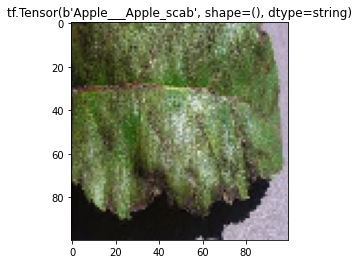

In [ ]:
for img, label in test_ds:
  h = np.ravel(model.predict(img))
  print(h)
  idx = tf.math.argmax(h)
  print(idx)
  print(classes[idx])
  img = np.squeeze(img, axis = 0)
  label = np.squeeze(label, axis = 0)
  plt.imshow(img.astype("uint8"))
  plt.title(class_names[label])

  break